## Primero se cargan todas la imagenes en la carpeta res, para que sea más fácil trabajar con ellas, pero de momento se trabaja con una sola

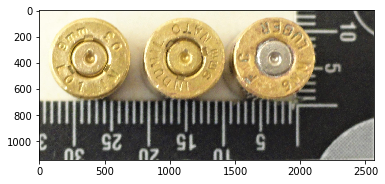

In [62]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


listaImagenes = []
for imagen in os.listdir("res"):
    img = cv2.imread("res/"+(imagen), cv2.IMREAD_COLOR)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    listaImagenes.append(im_rgb)


img = listaImagenes[8]
plt.imshow(img)



## Hacemos las transformaciones necesarias para realzar detalles de la imagen


### Primero definimos las funciones necesarias para aplicar las transformaciones

In [63]:
def apply_f_on_rgb(img, f, args):
    """
    Función para aplicar una transformación a la imagen
    ----
    Parameters:
        img: imagen a la que le aplicaremos la transformación \n
        f: vble tipo función \n
        args: otros argumentos
    """
    #Crear una matriz de ceros del tamaño de la imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Aplicar la transformación f sobre cada canal del espacio de color RGB
    res[:,:,0] = f(img[:,:,0], *args)
    res[:,:,1] = f(img[:,:,1], *args)
    res[:,:,2] = f(img[:,:,2], *args)
    
    return res

def histogram_expansion(img):
    
    #Crear matriz de ceros del tamaño de la imagen y tipo de dato flotante
    res = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)
    
    #Extraer el mínimo y el máximo del conjunto de datos
    m = float(np.min(img))
    M = float(np.max(img))
    #Aplicar la función de expansión(normalización) y asegurar datos uint8
    res = (img-m)*255.0/(M-m)
    res = res.astype(np.uint8)
    
    return res

def non_linear_parabola(img, a, b, c):
    
    #Crear copia de la imagen con datos flotantes dado que se normalizarán
    img_copy = img.astype(np.float32)/255.0
    #Una parábola tiene la forma ax² + bx + c, donde x es la imagen de entrada
    #A partir de la imagen, generar ax²
    res_a = cv2.pow(img_copy,2)
    res_a = cv2.multiply(res_a,a)
    #Generar bx
    res_b = cv2.multiply(img_copy,b)
    #Sumar ax² + bx + c
    res = cv2.add(res_a, res_b)
    res = cv2.add(res, c)
    #Asegurar que los datos queden entre 0 y 255 y regresar al dato uint8
    res[res < 0 ] = 0
    res = res*255
    res[res > 255] = 255
    res = res.astype(np.uint8)
    
    return res 

#### Aplicamos las transformaciones a la imagen

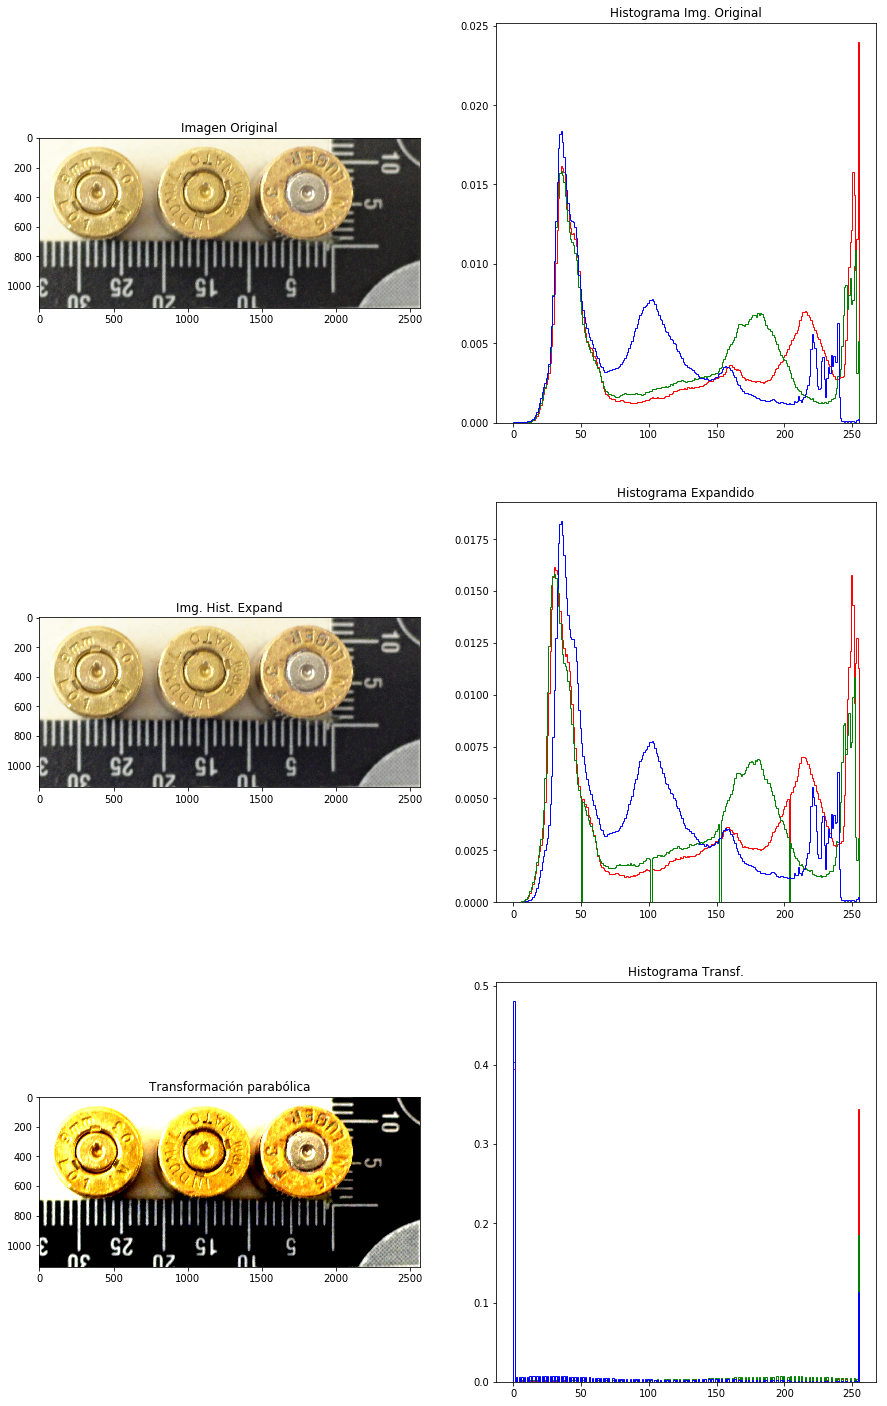

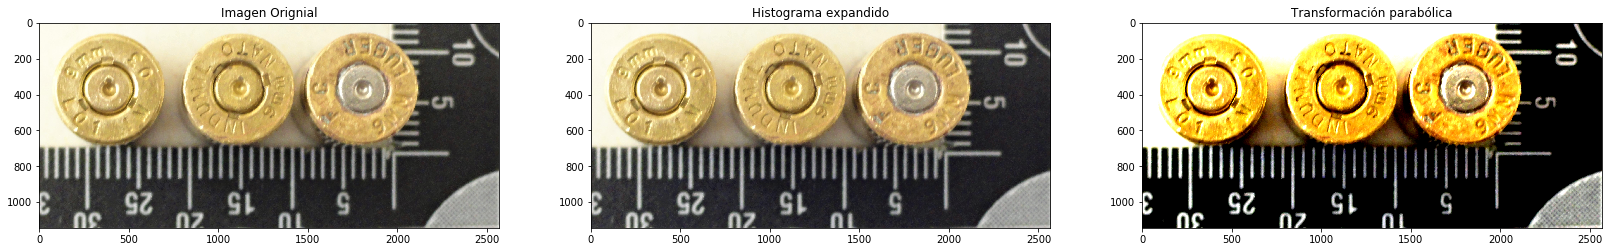

In [64]:
img_orig = img

# 1. Expandimos el histograma

img_exp = apply_f_on_rgb(img, histogram_expansion, [])

# 2. Aplicamos una transformacion de parábola no lineal
# ax² + bx + c
a = 1.1 #0.8
b = 1.1
c = -0.5
#Canal L con a= 1.1 c = -0.5 b = 1.1 detecta 3
img_parab = apply_f_on_rgb(img_exp, non_linear_parabola,(a , b, c))

#------------------ PLOTEO-----------------

#Creamos algunas listas con Títulos, colores y el orden de las imágenes
titulos=[["Imagen Original","Histograma Img. Original"],["Img. Hist. Expand", "Histograma Expandido"],["Transformación parabólica","Histograma Transf."]]
imagenes=[img_orig,img_exp,img_parab]
colors = ('r','g','b')
cmaps = ("Reds","Greens","Blues","gray","gray","gray")

#Se crea un arreglo de subplots con 6 filas para los 6 canales y 2 columnas para la imagen e Histograma
fig, arreglo_plots = plt.subplots(len(imagenes),2, figsize=(15, 25))

#Se muestran las imágenes en cada uno de sus canales en la primer columna del arreglo de sub plots y sus histogramas en la 2da
for i in range(len(imagenes)):
    
    arreglo_plots[i,0].imshow(imagenes[i], cmap=cmaps[i])
     
    img_array_i = imagenes[i][:,:,0]
    arreglo_plots[i,1].hist(img_array_i.ravel(),histtype='step', bins=255, range=(0.0, 255.0),normed=True, color=colors[0])
    
    img_array_i = imagenes[i][:,:,1]
    arreglo_plots[i,1].hist(img_array_i.ravel(),histtype='step', bins=255, range=(0.0, 255.0),normed=True, color=colors[1])
    
    img_array_i = imagenes[i][:,:,2]
    arreglo_plots[i,1].hist(img_array_i.ravel(),histtype='step', bins=255, range=(0.0, 255.0),normed=True, color=colors[2])
    
    for k in range(0,2):
               
        arreglo_plots[i,k].set_title(titulos[i][k]);
        
fig, ((ax1, ax2,ax3)) = plt.subplots(1,3, figsize = (28,15))
ax1.imshow(img_orig)
ax1.set_title("Imagen Orignial")
ax2.imshow(img_exp)
ax2.set_title("Histograma expandido")
ax3.set_title("Transformación parabólica")
ax3.imshow(img_parab)

## Se separa la imagen por los canales de color de los espacios RGB y LAB

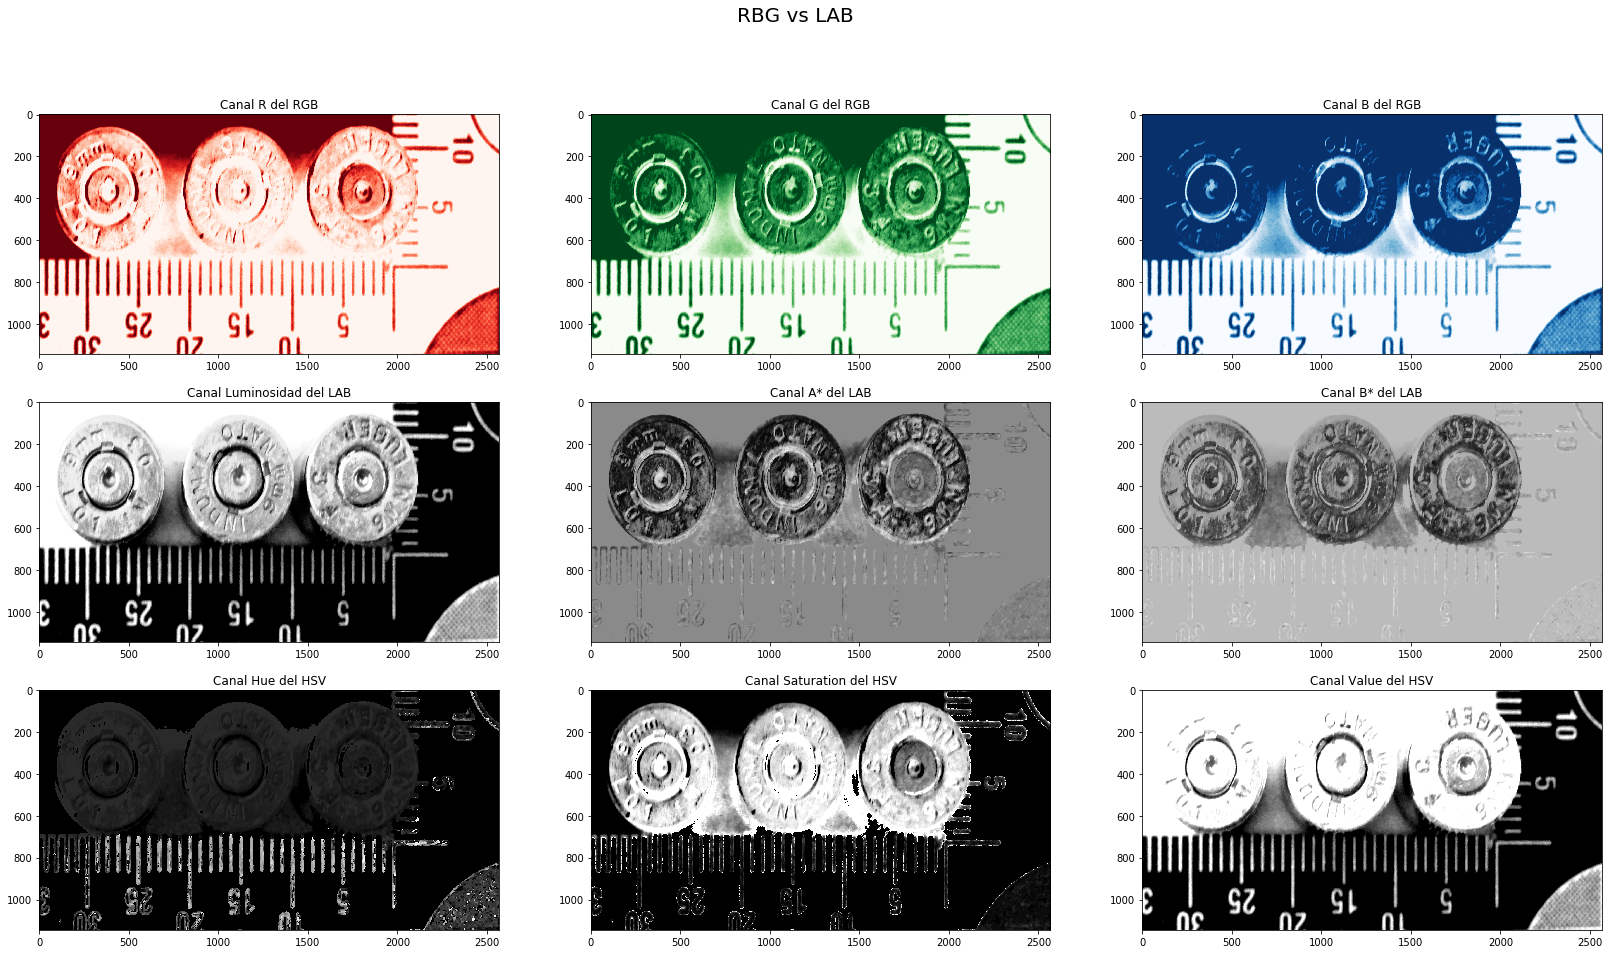

In [65]:
img = img_parab
img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_R = img_rgb[:,:,0]
img_G = img_rgb[:,:,1]
img_B = img_rgb[:,:,2]
img_lab  = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_L = img_lab[:,:,0]
img_A =  img_lab[:,:,1]
img_Bl = img_lab[:,:,2]
img_hsv  = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_H = img_hsv[:,:,0]
img_S =  img_hsv[:,:,1]
img_V = img_hsv[:,:,2]

#Canal RGB vs LAB vs HSV
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6),(ax7 , ax8, ax9)) = plt.subplots(3,3, figsize=(28, 15))
fig.suptitle('RBG vs LAB', fontsize=20)
ax1.set_title('Canal R del RGB')
ax1.imshow(img_R, cmap='Reds', aspect='auto')
ax2.set_title('Canal G del RGB')
ax2.imshow(img_G, cmap='Greens', aspect='auto')
ax3.set_title('Canal B del RGB')
ax3.imshow(img_B, cmap='Blues', aspect='auto')

ax4.set_title('Canal Luminosidad del LAB')
ax4.imshow(img_L, cmap='gray', aspect='auto')
ax5.set_title('Canal A* del LAB')
ax5.imshow(img_A, cmap='gray', aspect='auto')
ax6.set_title('Canal B* del LAB')
ax6.imshow(img_Bl, cmap='gray', aspect='auto')

ax7.set_title('Canal Hue del HSV')
ax7.imshow(img_H, cmap='gray', aspect='auto')
ax8.set_title('Canal Saturation del HSV')
ax8.imshow(img_S, cmap='gray', aspect='auto')
ax9.set_title('Canal Value del HSV')
ax9.imshow(img_V, cmap='gray', aspect='auto')

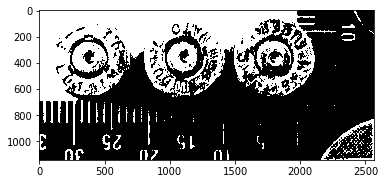

In [66]:
ret,thresh2 = cv2.threshold(img_L,180,255,cv2.THRESH_BINARY)
plt.imshow(thresh2, cmap='gray')

## Ahora tras elegir un canal se intenta usar ese para detectar que parte de la imagen es la vainilla

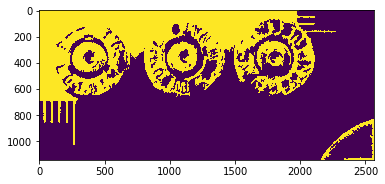

In [67]:
from skimage import morphology as morph

#selem = morph.rectangle(100,100)
#res = morph.closing(thresh2, selem)
#plt.imshow(res)
thresh2 = thresh2/255
res = morph.remove_small_holes(thresh2.astype(bool), area_threshold = 100)
res = morph.remove_small_objects(res, min_size = 8000)
plt.imshow(res)

Numero de vainillas detectadas: 3


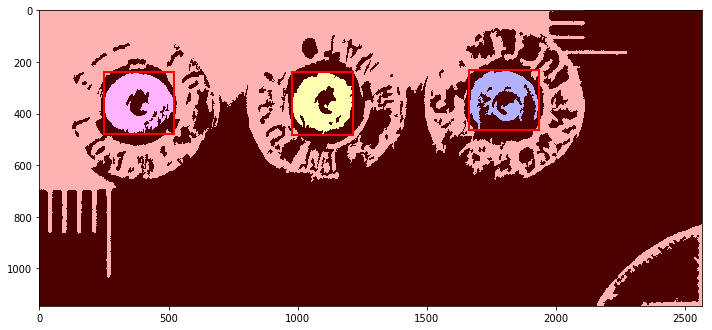

In [68]:

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
i = 0
for region in regionprops(label_image):
    i += 1
    # take regions with large enough areas
    if region.area >= 300:
        # draw rectangle 
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

#ax.set_axis_off()
plt.tight_layout()
print('Numero de vainillas detectadas: ' + str(i))
plt.show();